In [1]:
import json

import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import (Conv2D, SeparableConv2D, DepthwiseConv2D, BatchNormalization, MaxPooling2D, SpatialDropout2D,
                          LocallyConnected2D, Dense, Flatten, Dropout, Add)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2022-12-29 15:13:26.140921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 15:13:29.699664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-29 15:13:29.699820: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-29 15:13:29.699835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
count_map = {}

def generate_dense_blocks(features, num_blocks, input_layer, name_template="dense"):
    global count_map
    _l = input_layer
    for i in range(num_blocks):
        # _l = BatchNormalization()(_l)
        count_to_use = count_map.get(name_template, 1)
        _l = Dense(features, activation='relu', name=f"{name_template}_{count_to_use}")(_l)
        count_map[name_template] = count_to_use + 1
        # _l = Dropout(0.25)(_l)
    return _l

In [3]:
# Build the model
count_map = {}
activation = 'relu'
input_shape = 256
kernel = 3
pool = 2
padding = 'same'

dropout = 0.25

inputs = keras.Input(shape=input_shape)
features = 128
a = generate_dense_blocks(features, 1, inputs, name_template='a')
a1 = generate_dense_blocks(features, 1, a, name_template='a1')
a2 = generate_dense_blocks(features, 1, a, name_template='a2')
a = Add(name='sum_a')([a1,a2])
b = generate_dense_blocks(features, 1, inputs, name_template='b')
b1 = generate_dense_blocks(features, 2, b, name_template='b1')
b2 = generate_dense_blocks(features, 2, b, name_template='b2')
b = Add(name='sum_b')([b1, b2])
b = generate_dense_blocks(features, 2, b, name_template='b')
# c = generate_dense_blocks(features, 3, inputs, name_template='c')

a = Add(name='sum_ab')([a, b])

d = generate_dense_blocks(features, 2, a, name_template='d')
e = generate_dense_blocks(features, 3, a, name_template='e')
# e1 = generate_dense_blocks(features, 2, e, name_template='e1')
e1 = generate_dense_blocks(features, 2, e, name_template='e1')
e2 = Add(name="sum_b2_e")([e, b2])
e2 = generate_dense_blocks(features, 2, e2, name_template='e2')
# f = generate_dense_blocks(features,4, a, name_template='f')
e = Add(name='sum_e')([e1,e2])
g = Add(name='sum_d_e')([d, e])

y = Dropout(dropout, name='dropout_out')(g)
outputs = Dense(10, name='output', activation='softmax')(y)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

2022-12-29 15:13:32.466490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:13:32.806103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:13:32.807550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 15:13:32.811778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 b_1 (Dense)                    (None, 128)          32896       ['input_1[0][0]']                
                                                                                                  
 b1_1 (Dense)                   (None, 128)          16512       ['b_1[0][0]']                    
                                                                                                  
 b2_1 (Dense)                   (None, 128)          16512       ['b_1[0][0]']                    
                                                                                              

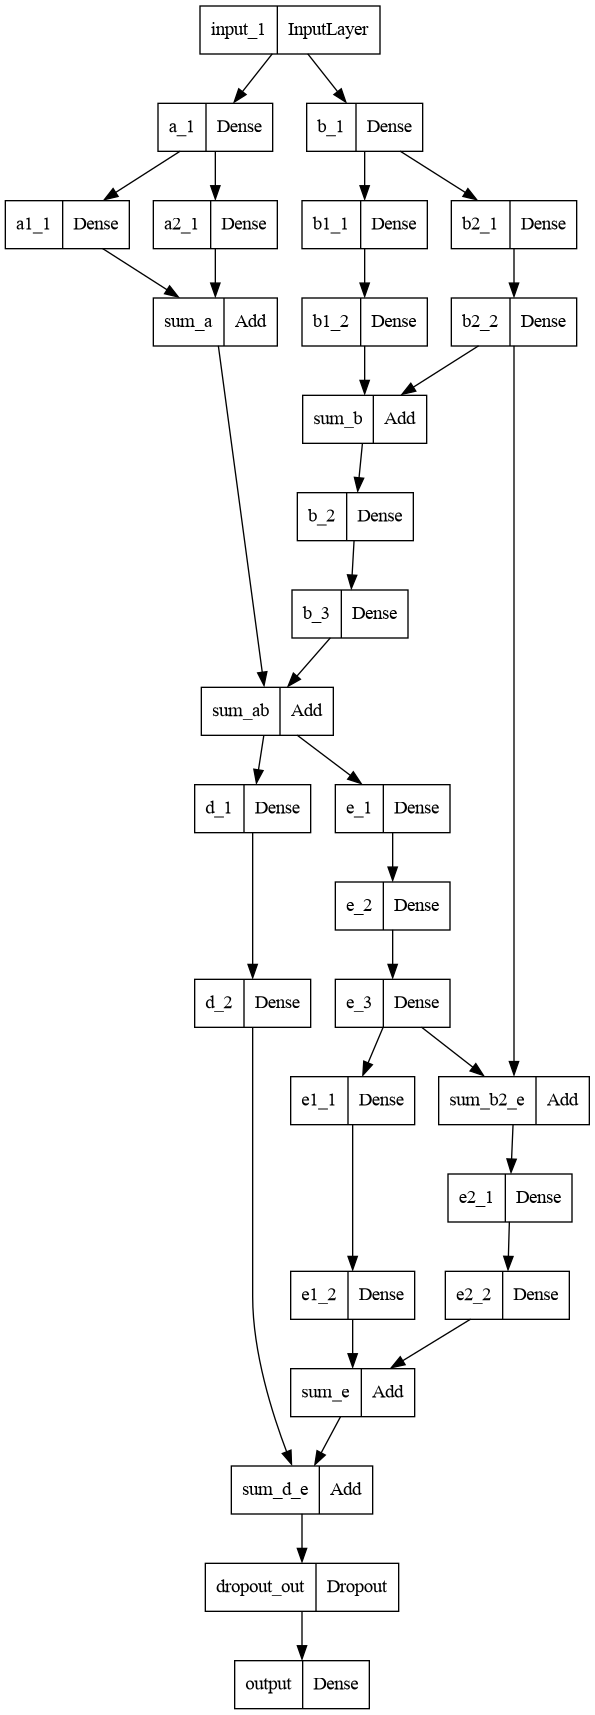

In [4]:
from keras.utils import plot_model

plot_model(model, show_shapes=False, show_dtype=False, show_layer_activations=False, show_layer_names=True)

In [5]:
model.save("model.h5")

In [6]:
subgraph_start = []
subgraph_end = []

In [7]:
def get_layer_outbound_layers(layer: keras.layers.Layer):
    outbound_layers = []
    for outbound_node in layer.outbound_nodes:
        outbound_layers.append(outbound_node.outbound_layer)

    return outbound_layers


def get_all_outward_layers(layer: keras.layers.Layer, stop_at_subgraph_end=True):
    queue = get_layer_outbound_layers(layer)
    out = []
    while len(queue) > 0:
        l = queue.pop()
        out.append(l)
        if not stop_at_subgraph_end or l not in subgraph_end:
            queue.extend(get_layer_outbound_layers(l))
    return out


def get_layer_inbound_layers(layer: keras.layers.Layer):
    inbound_layers = []
    for inbound_node in layer.inbound_nodes:
        if isinstance(inbound_node.inbound_layers, list):
            for inbound_layer in inbound_node.inbound_layers:
                inbound_layers.append(inbound_layer)
        else:
            inbound_layers.append(inbound_node.inbound_layers)

    return inbound_layers


def get_all_inward_layers(layer: keras.layers.Layer, stop_at_subgraph_start=True):
    queue = get_layer_inbound_layers(layer)
    out = []
    while len(queue) > 0:
        l = queue.pop()
        out.append(l)
        if not stop_at_subgraph_start or l not in subgraph_start:
            queue.extend(get_layer_inbound_layers(l))
    return out

In [8]:
adjacency = {l.name : {ll.name: 0 for ll in model.layers} for l in model.layers}
for l in model.layers:
    for ol in get_layer_outbound_layers(l):
        adjacency[l.name][ol.name] = 1

adj = pd.DataFrame(adjacency)
adj

,input_1,b_1,b1_1,b2_1,b1_2,b2_2,a_1,sum_b,a1_1,a2_1,...,e1_1,e2_1,d_1,e1_2,e2_2,d_2,sum_e,sum_d_e,dropout_out,output
input_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b_1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b1_1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b2_1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b1_2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
b2_2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a_1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sum_b,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a1_1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a2_1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: >

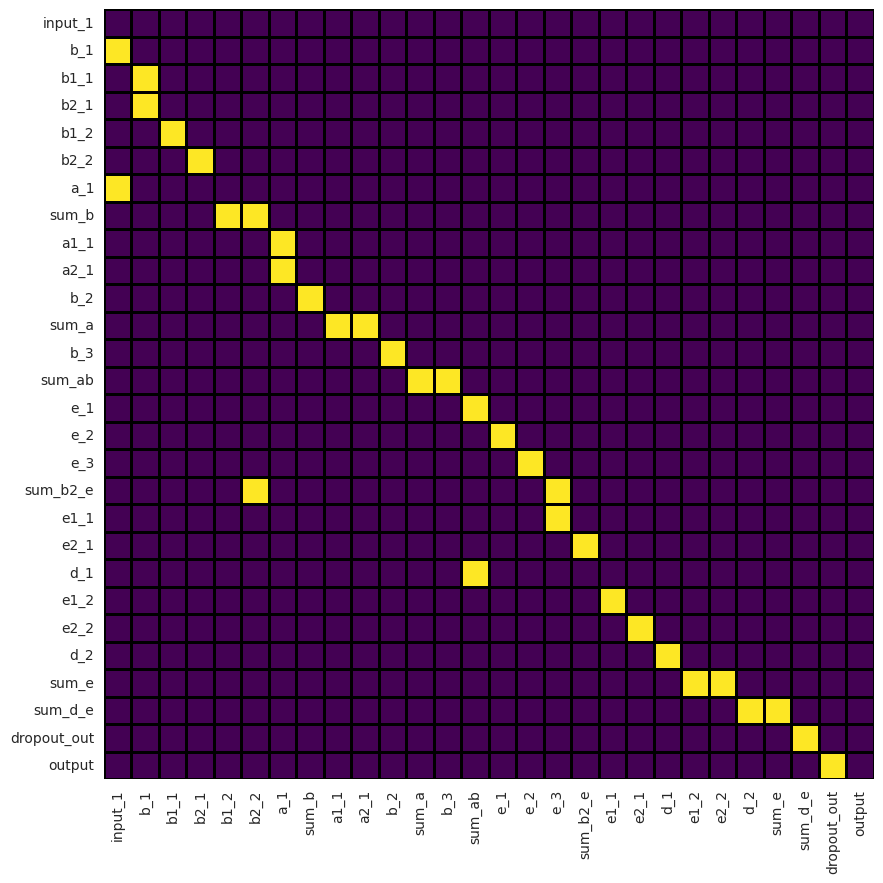

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(adj, square=True, cbar=False, cmap='viridis', linewidths=1, linecolor='black', )

In [18]:
adj_list = {l.name: [ol for ol in adjacency[l.name] if adjacency[l.name][ol] == 1] for l in model.layers}
adj_list

{'input_1': ['b_1', 'a_1'],
 'b_1': ['b1_1', 'b2_1'],
 'b1_1': ['b1_2'],
 'b2_1': ['b2_2'],
 'b1_2': ['sum_b'],
 'b2_2': ['sum_b', 'sum_b2_e'],
 'a_1': ['a1_1', 'a2_1'],
 'sum_b': ['b_2'],
 'a1_1': ['sum_a'],
 'a2_1': ['sum_a'],
 'b_2': ['b_3'],
 'sum_a': ['sum_ab'],
 'b_3': ['sum_ab'],
 'sum_ab': ['e_1', 'd_1'],
 'e_1': ['e_2'],
 'e_2': ['e_3'],
 'e_3': ['sum_b2_e', 'e1_1'],
 'sum_b2_e': ['e2_1'],
 'e1_1': ['e1_2'],
 'e2_1': ['e2_2'],
 'd_1': ['d_2'],
 'e1_2': ['sum_e'],
 'e2_2': ['sum_e'],
 'd_2': ['sum_d_e'],
 'sum_e': ['sum_d_e'],
 'sum_d_e': ['dropout_out'],
 'dropout_out': ['output'],
 'output': []}

In [10]:
layer_map = {}
for layer in model.layers:
    layer_map[layer.name] = layer

print(f"there are {len(layer_map)} layers")

there are 28 layers


In [11]:
subgraph_start = set()

for layer in model.layers:
    outbound_layers = get_layer_outbound_layers(layer)
    if len(outbound_layers) > 1:
        print(f"detected subgraph start for layer {layer.name} with {len(outbound_layers)} outbound layers")
        subgraph_start.add(layer)

detected subgraph start for layer input_1 with 2 outbound layers
detected subgraph start for layer b_1 with 2 outbound layers
detected subgraph start for layer b2_2 with 2 outbound layers
detected subgraph start for layer a_1 with 2 outbound layers
detected subgraph start for layer sum_ab with 2 outbound layers
detected subgraph start for layer e_3 with 2 outbound layers


In [12]:
subgraph_end = set()
for layer in model.layers:
    inbound_layers = get_layer_inbound_layers(layer)
    if len(inbound_layers) > 1:
        print(f"detected subgraph end for layer {layer.name} with {len(inbound_layers)} inbound layers")
        subgraph_end.add(layer)

detected subgraph end for layer sum_b with 2 inbound layers
detected subgraph end for layer sum_a with 2 inbound layers
detected subgraph end for layer sum_ab with 2 inbound layers
detected subgraph end for layer sum_b2_e with 2 inbound layers
detected subgraph end for layer sum_e with 2 inbound layers
detected subgraph end for layer sum_d_e with 2 inbound layers


In [13]:
subgraph_start = list(subgraph_start)
subgraph_end = list(subgraph_end)

outward_map = {}
# inward_map = {}

for start in subgraph_start:
    outward_layers = get_all_outward_layers(start, True)
    outward_layer_names = [l.name for l in outward_layers]
    outward_map[start.name] = outward_layer_names

In [14]:
subgraph_start = list(subgraph_start)
subgraph_end = list(subgraph_end)

outward_map = {}
# inward_map = {}

for start in subgraph_start:
    outward_layers = get_all_outward_layers(start, True)
    outward_layer_names = [l.name for l in outward_layers]
    outward_map[start.name] = outward_layer_names

compatiblity_down = {}
# compatiblity_up = {}

for start, nodes in outward_map.items():
    c = nodes.copy()
    for node in nodes:
        if node not in [s.name for s in subgraph_end]:
            c.remove(node)

    c = set(c)
    compatiblity_down[start] = list(c)


compatibility = {}

for start in subgraph_start:
    compat_row = compatibility.get(start.name, {})
    for end in subgraph_end:
        compat_row[end.name] = int(end.name in compatiblity_down[start.name])
    compatibility[start.name] = compat_row

df = pd.DataFrame(compatibility)
df.transpose()

,sum_e,sum_d_e,sum_a,sum_b2_e,sum_ab,sum_b
b2_2,0,0,0,1,0,1
e_3,1,0,0,1,0,0
input_1,0,0,1,1,0,1
a_1,0,0,1,0,0,0
sum_ab,1,1,0,1,0,0
b_1,0,0,0,1,0,1


In [15]:
subgraph_start = list(subgraph_start)
subgraph_end = list(subgraph_end)

outward_map = {}
# inward_map = {}

for start in subgraph_start:
    outward_layers = get_all_outward_layers(start, False)
    outward_layer_names = [l.name for l in outward_layers]
    outward_map[start.name] = outward_layer_names

compatiblity_down = {}
# compatiblity_up = {}

for start, nodes in outward_map.items():
    c = nodes.copy()
    for node in nodes:
        if node not in [s.name for s in subgraph_end]:
            c.remove(node)

    c = set(c)
    compatiblity_down[start] = list(c)


compatibility = {}

for start in subgraph_start:
    compat_row = compatibility.get(start.name, {})
    for end in subgraph_end:
        compat_row[end.name] = int(end.name in compatiblity_down[start.name])
    compatibility[start.name] = compat_row

import pandas as pd
df = pd.DataFrame(compatibility)
df.transpose()

,sum_e,sum_d_e,sum_a,sum_b2_e,sum_ab,sum_b
b2_2,1,1,0,1,1,1
e_3,1,1,0,1,0,0
input_1,1,1,1,1,1,1
a_1,1,1,1,1,1,0
sum_ab,1,1,0,1,0,0
b_1,1,1,0,1,1,1


In [16]:
df.sum(axis=1)

sum_e       6
sum_d_e     6
sum_a       2
sum_b2_e    6
sum_ab      4
sum_b       3
dtype: int64

In [17]:
parent_map = {}
for input_name in model.input_names:
    curr_layer = layer_map[input_name]

    q = [(0, curr_layer)]
    while len(q) != 0:
        num_steps, layer = q.pop()
        for ol in get_layer_outbound_layers(layer):
            t = parent_map.get(ol.name, [])
            t.append((num_steps + 1, layer.name))
            parent_map[ol.name] = t
            q.append((num_steps + 1, ol))

parent_map

{'a_1': [(1, 'input_1')],
 'b_1': [(1, 'input_1')],
 'b1_1': [(2, 'b_1')],
 'b2_1': [(2, 'b_1')],
 'b2_2': [(3, 'b2_1')],
 'sum_b': [(4, 'b2_2'), (4, 'b1_2')],
 'sum_b2_e': [(4, 'b2_2'), (11, 'e_3'), (11, 'e_3'), (8, 'e_3'), (8, 'e_3')],
 'e2_1': [(5, 'sum_b2_e'),
  (12, 'sum_b2_e'),
  (12, 'sum_b2_e'),
  (9, 'sum_b2_e'),
  (9, 'sum_b2_e')],
 'e2_2': [(6, 'e2_1'), (13, 'e2_1'), (13, 'e2_1'), (10, 'e2_1'), (10, 'e2_1')],
 'sum_e': [(7, 'e2_2'),
  (14, 'e2_2'),
  (13, 'e1_2'),
  (14, 'e2_2'),
  (13, 'e1_2'),
  (11, 'e2_2'),
  (10, 'e1_2'),
  (11, 'e2_2'),
  (10, 'e1_2')],
 'sum_d_e': [(8, 'sum_e'),
  (15, 'sum_e'),
  (14, 'sum_e'),
  (10, 'd_2'),
  (15, 'sum_e'),
  (14, 'sum_e'),
  (10, 'd_2'),
  (12, 'sum_e'),
  (11, 'sum_e'),
  (7, 'd_2'),
  (12, 'sum_e'),
  (11, 'sum_e'),
  (7, 'd_2')],
 'dropout': [(9, 'sum_d_e'),
  (16, 'sum_d_e'),
  (15, 'sum_d_e'),
  (11, 'sum_d_e'),
  (16, 'sum_d_e'),
  (15, 'sum_d_e'),
  (11, 'sum_d_e'),
  (13, 'sum_d_e'),
  (12, 'sum_d_e'),
  (8, 'sum_d_e'),
  